In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from keras.layers.core import Activation, Dropout
from keras.callbacks import EarlyStopping
import time
from matplotlib import pyplot
import numpy
import random
from keras_self_attention import SeqSelfAttention
from tcn import TCN
import tensorflow as tf
import time
start_time = time.time()

# IMF2

<Figure size 2000x800 with 0 Axes>

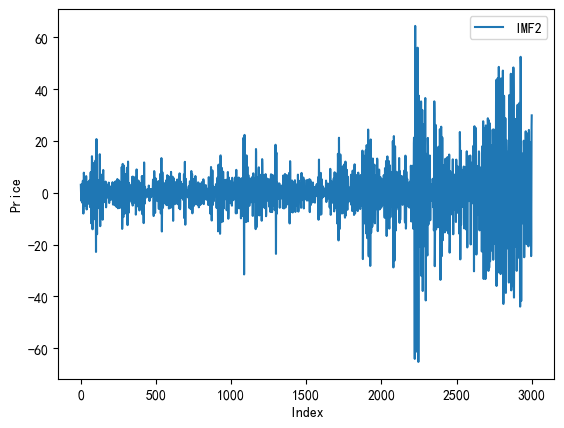

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 256)           133120    
 l)                                                              
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn (TCN)                   (None, 32)                39200     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

68/68 [==============================] - 1s 9ms/step - loss: 6.8471e-04 - mae: 0.0193 - val_loss: 0.0059 - val_mae: 0.0537
Epoch 53/200
68/68 [==============================] - 1s 9ms/step - loss: 6.5191e-04 - mae: 0.0187 - val_loss: 0.0062 - val_mae: 0.0542
Epoch 54/200
68/68 [==============================] - 1s 9ms/step - loss: 6.7739e-04 - mae: 0.0189 - val_loss: 0.0063 - val_mae: 0.0552
Epoch 55/200
68/68 [==============================] - 1s 9ms/step - loss: 7.0902e-04 - mae: 0.0196 - val_loss: 0.0059 - val_mae: 0.0531
Epoch 56/200
68/68 [==============================] - 1s 9ms/step - loss: 6.7291e-04 - mae: 0.0190 - val_loss: 0.0061 - val_mae: 0.0547
Epoch 57/200
68/68 [==============================] - 1s 9ms/step - loss: 7.1128e-04 - mae: 0.0198 - val_loss: 0.0061 - val_mae: 0.0542
Epoch 58/200
68/68 [==============================] - 1s 9ms/step - loss: 7.2795e-04 - mae: 0.0204 - val_loss: 0.0054 - val_mae: 0.0513
Epoch 59/200
68/68 [==============================] - 1s 9ms/

Epoch 112/200
68/68 [==============================] - 1s 12ms/step - loss: 3.6763e-04 - mae: 0.0139 - val_loss: 0.0036 - val_mae: 0.0402
Epoch 112: early stopping
75/75 [==============================] - 0s 4ms/step - loss: 5.6268e-04 - mae: 0.0144
0.0005626801867038012 0.014358244836330414
19/19 [==============================] - 1s 4ms/step
Test Sccore 108.3578 MAPE
Test Score: 4.7496 MAE
Test Score: 6.6117 RMSE


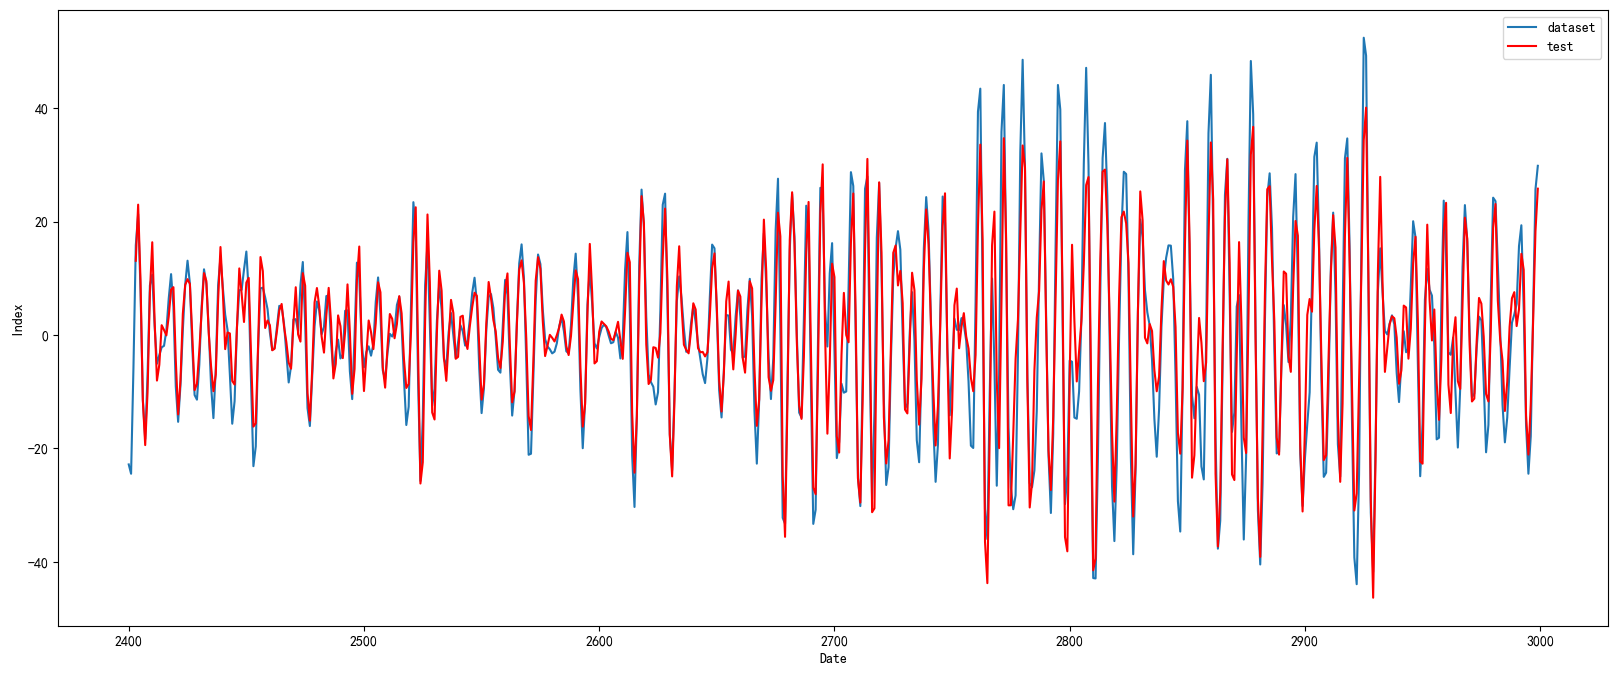

In [2]:
seed_value = 6
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index High modes_data.csv', index_col=0,usecols=[0,2])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF2_pre= pd.DataFrame(testPredict)
IMF2_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF3

<Figure size 2000x800 with 0 Axes>

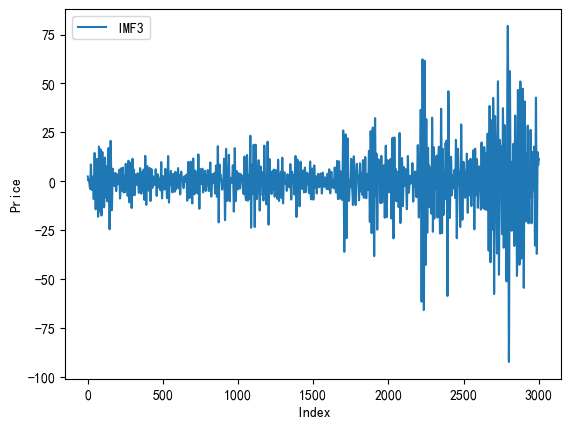

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 3, 64)            8704      
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 64)            4161      
 )                                                               
                                                                 
 tcn_1 (TCN)                 (None, 32)                20768     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

68/68 [==============================] - 0s 7ms/step - loss: 3.9104e-04 - mae: 0.0147 - val_loss: 0.0011 - val_mae: 0.0234
Epoch 53/100
68/68 [==============================] - 0s 7ms/step - loss: 3.0010e-04 - mae: 0.0126 - val_loss: 9.2145e-04 - val_mae: 0.0208
Epoch 54/100
68/68 [==============================] - 0s 7ms/step - loss: 3.8952e-04 - mae: 0.0146 - val_loss: 0.0011 - val_mae: 0.0242
Epoch 55/100
68/68 [==============================] - 0s 7ms/step - loss: 3.0063e-04 - mae: 0.0131 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 56/100
68/68 [==============================] - 1s 8ms/step - loss: 3.3526e-04 - mae: 0.0137 - val_loss: 0.0011 - val_mae: 0.0233
Epoch 57/100
68/68 [==============================] - 0s 7ms/step - loss: 3.6536e-04 - mae: 0.0144 - val_loss: 0.0014 - val_mae: 0.0270
Epoch 58/100
68/68 [==============================] - 0s 7ms/step - loss: 3.3436e-04 - mae: 0.0136 - val_loss: 0.0010 - val_mae: 0.0215
Epoch 59/100
68/68 [==============================] - 0s 

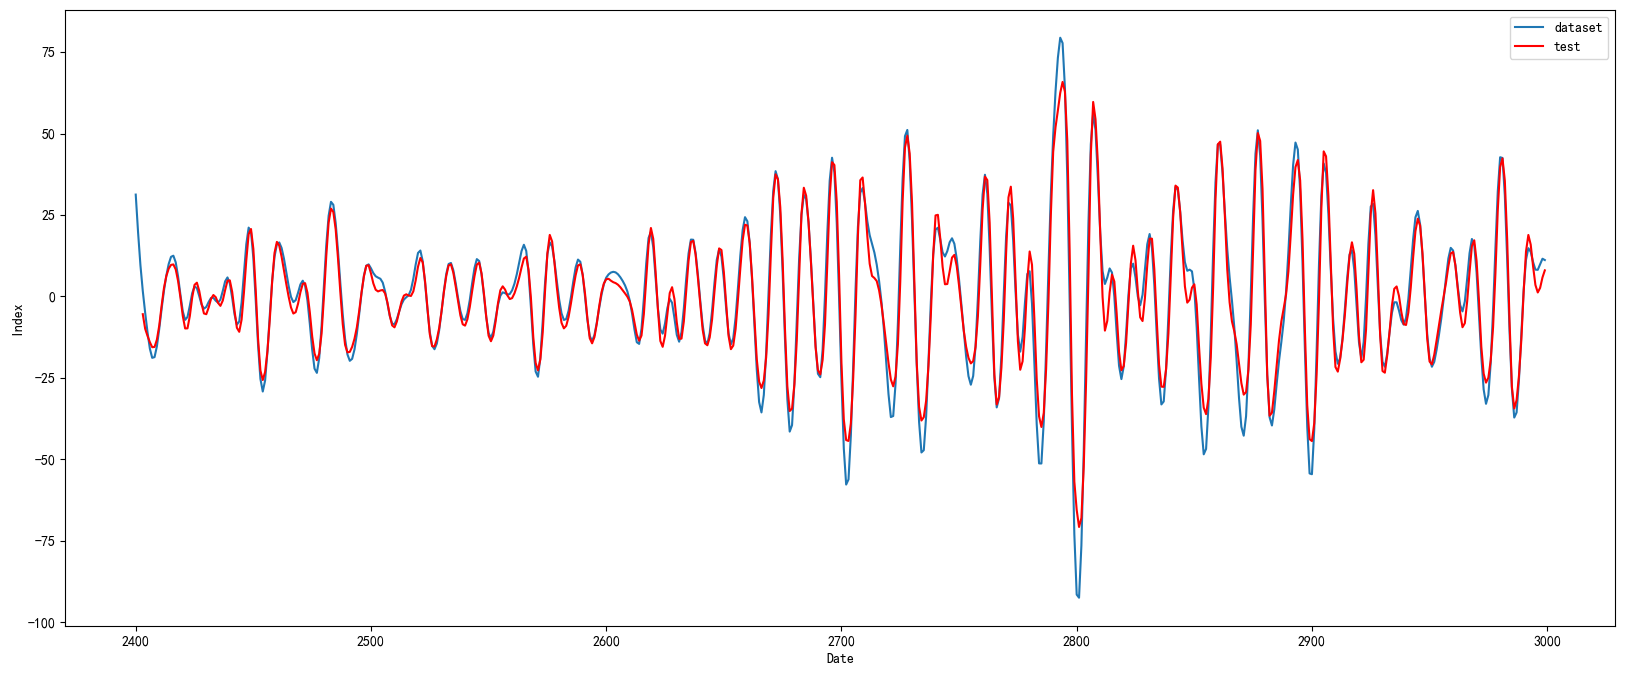

In [3]:
seed_value = 6
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index High modes_data.csv', index_col=0,usecols=[0,3])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(32,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF3_pre= pd.DataFrame(testPredict)
IMF3_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF4

<Figure size 2000x800 with 0 Axes>

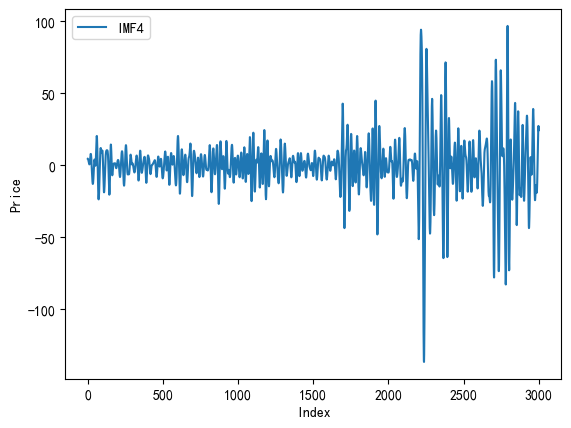

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_2 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 activation_2 (Activation)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

68/68 [==============================] - 1s 9ms/step - loss: 3.8647e-04 - mae: 0.0156 - val_loss: 0.0020 - val_mae: 0.0337
Epoch 53/100
68/68 [==============================] - 1s 10ms/step - loss: 3.4613e-04 - mae: 0.0143 - val_loss: 0.0015 - val_mae: 0.0293
Epoch 54/100
68/68 [==============================] - 1s 9ms/step - loss: 3.2409e-04 - mae: 0.0136 - val_loss: 9.8682e-04 - val_mae: 0.0235
Epoch 55/100
68/68 [==============================] - 1s 10ms/step - loss: 2.6241e-04 - mae: 0.0126 - val_loss: 0.0011 - val_mae: 0.0253
Epoch 56/100
68/68 [==============================] - 1s 10ms/step - loss: 4.1603e-04 - mae: 0.0157 - val_loss: 0.0017 - val_mae: 0.0314
Epoch 57/100
68/68 [==============================] - 1s 9ms/step - loss: 2.6569e-04 - mae: 0.0120 - val_loss: 0.0010 - val_mae: 0.0234
Epoch 58/100
68/68 [==============================] - 1s 10ms/step - loss: 3.3353e-04 - mae: 0.0144 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 59/100
68/68 [==============================] -

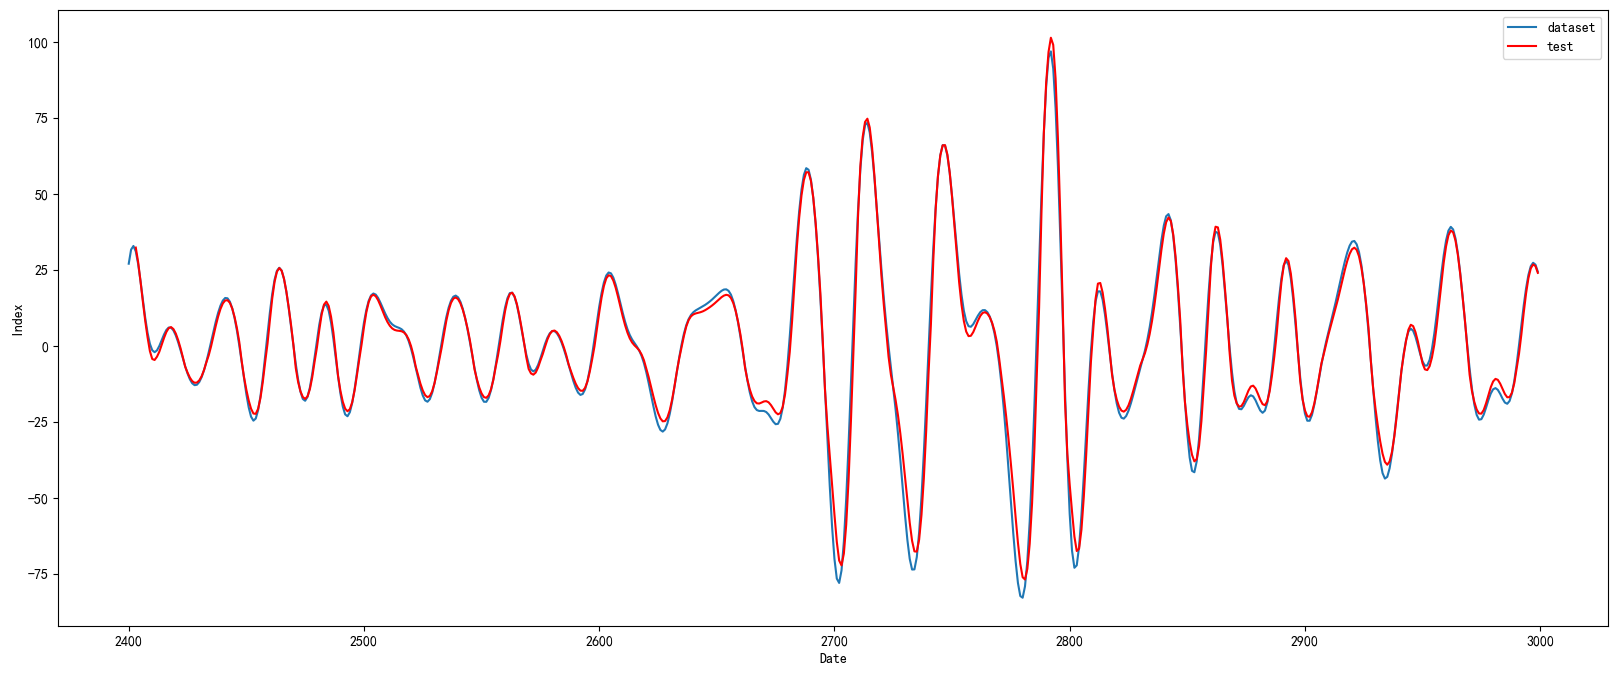

In [4]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index High modes_data.csv', index_col=0,usecols=[0,4])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF4_pre= pd.DataFrame(testPredict)
IMF4_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF5

<Figure size 2000x800 with 0 Axes>

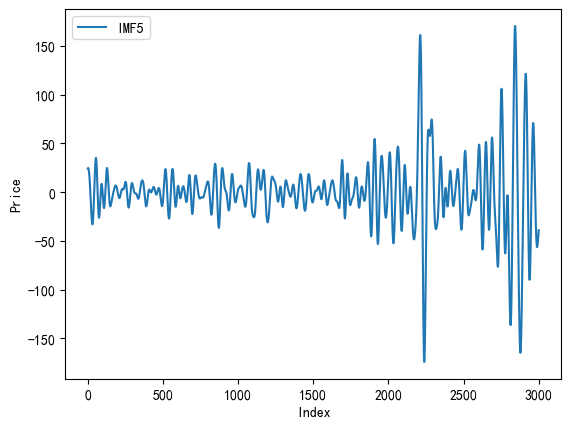

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 3, 128)           33792     
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_3 (TCN)                 (None, 32)                26912     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 activation_3 (Activation)   (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

68/68 [==============================] - 1s 8ms/step - loss: 2.7642e-04 - mae: 0.0125 - val_loss: 0.0012 - val_mae: 0.0242
Epoch 53/200
68/68 [==============================] - 1s 8ms/step - loss: 2.9702e-04 - mae: 0.0130 - val_loss: 0.0012 - val_mae: 0.0248
Epoch 54/200
68/68 [==============================] - 1s 8ms/step - loss: 3.1729e-04 - mae: 0.0133 - val_loss: 0.0015 - val_mae: 0.0279
Epoch 55/200
68/68 [==============================] - 1s 8ms/step - loss: 2.7247e-04 - mae: 0.0128 - val_loss: 0.0014 - val_mae: 0.0272
Epoch 56/200
68/68 [==============================] - 1s 8ms/step - loss: 3.0379e-04 - mae: 0.0133 - val_loss: 0.0015 - val_mae: 0.0271
Epoch 57/200
68/68 [==============================] - 1s 8ms/step - loss: 2.7166e-04 - mae: 0.0125 - val_loss: 0.0015 - val_mae: 0.0282
Epoch 58/200
68/68 [==============================] - 1s 8ms/step - loss: 2.6046e-04 - mae: 0.0124 - val_loss: 0.0013 - val_mae: 0.0246
Epoch 59/200
68/68 [==============================] - 1s 8ms/

68/68 [==============================] - 1s 8ms/step - loss: 1.2334e-04 - mae: 0.0081 - val_loss: 4.4876e-04 - val_mae: 0.0154
Epoch 112/200
68/68 [==============================] - 1s 8ms/step - loss: 1.1097e-04 - mae: 0.0078 - val_loss: 5.0402e-04 - val_mae: 0.0147
Epoch 113/200
68/68 [==============================] - 1s 8ms/step - loss: 1.3941e-04 - mae: 0.0087 - val_loss: 5.7387e-04 - val_mae: 0.0164
Epoch 114/200
68/68 [==============================] - 1s 8ms/step - loss: 1.1441e-04 - mae: 0.0079 - val_loss: 4.7768e-04 - val_mae: 0.0142
Epoch 115/200
68/68 [==============================] - 1s 8ms/step - loss: 1.2906e-04 - mae: 0.0084 - val_loss: 3.9749e-04 - val_mae: 0.0140
Epoch 116/200
68/68 [==============================] - 1s 8ms/step - loss: 1.0804e-04 - mae: 0.0075 - val_loss: 4.7376e-04 - val_mae: 0.0157
Epoch 117/200
68/68 [==============================] - 1s 9ms/step - loss: 1.2678e-04 - mae: 0.0083 - val_loss: 3.4841e-04 - val_mae: 0.0140
Epoch 118/200
68/68 [======

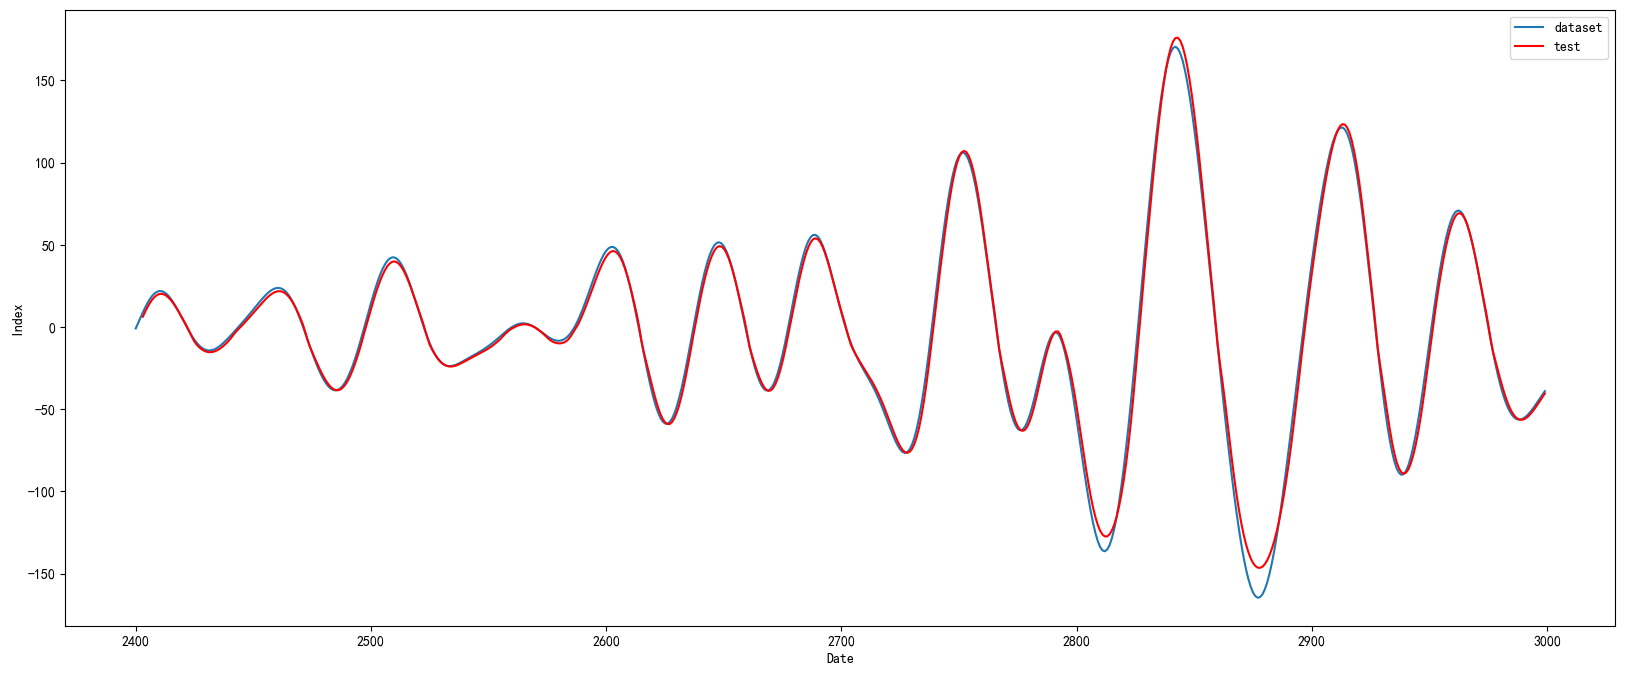

In [5]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index High modes_data.csv', index_col=0,usecols=[0,5])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF5_pre= pd.DataFrame(testPredict)
IMF5_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF6

<Figure size 2000x800 with 0 Axes>

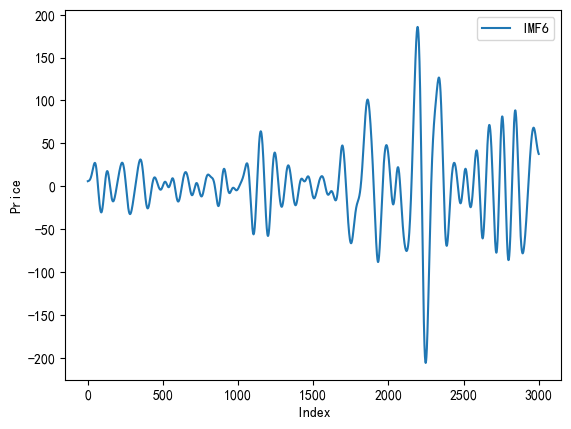

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_4 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 activation_4 (Activation)   (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

Epoch 52/200
68/68 [==============================] - 1s 10ms/step - loss: 3.3482e-04 - mae: 0.0129 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 53/200
68/68 [==============================] - 1s 10ms/step - loss: 3.5250e-04 - mae: 0.0135 - val_loss: 7.8886e-04 - val_mae: 0.0240
Epoch 54/200
68/68 [==============================] - 1s 10ms/step - loss: 3.6617e-04 - mae: 0.0137 - val_loss: 0.0013 - val_mae: 0.0278
Epoch 55/200
68/68 [==============================] - 1s 10ms/step - loss: 3.1281e-04 - mae: 0.0127 - val_loss: 9.2917e-04 - val_mae: 0.0261
Epoch 56/200
68/68 [==============================] - 1s 10ms/step - loss: 3.8566e-04 - mae: 0.0146 - val_loss: 8.4241e-04 - val_mae: 0.0228
Epoch 57/200
68/68 [==============================] - 1s 10ms/step - loss: 3.6225e-04 - mae: 0.0136 - val_loss: 0.0010 - val_mae: 0.0269
Epoch 58/200
68/68 [==============================] - 1s 10ms/step - loss: 3.4089e-04 - mae: 0.0130 - val_loss: 9.1899e-04 - val_mae: 0.0257
Epoch 59/200
68/68 [=====

68/68 [==============================] - 1s 11ms/step - loss: 2.2378e-04 - mae: 0.0102 - val_loss: 7.5852e-04 - val_mae: 0.0239
Epoch 111/200
68/68 [==============================] - 1s 12ms/step - loss: 1.9067e-04 - mae: 0.0094 - val_loss: 7.0209e-04 - val_mae: 0.0234
Epoch 112/200
68/68 [==============================] - 1s 11ms/step - loss: 1.8377e-04 - mae: 0.0097 - val_loss: 7.7971e-04 - val_mae: 0.0235
Epoch 113/200
68/68 [==============================] - 1s 11ms/step - loss: 2.0383e-04 - mae: 0.0097 - val_loss: 5.5928e-04 - val_mae: 0.0197
Epoch 114/200
68/68 [==============================] - 1s 10ms/step - loss: 1.8103e-04 - mae: 0.0094 - val_loss: 6.9476e-04 - val_mae: 0.0205
Epoch 115/200
68/68 [==============================] - 1s 9ms/step - loss: 1.8638e-04 - mae: 0.0095 - val_loss: 4.5541e-04 - val_mae: 0.0182
Epoch 116/200
68/68 [==============================] - 1s 10ms/step - loss: 1.7831e-04 - mae: 0.0091 - val_loss: 4.2323e-04 - val_mae: 0.0173
Epoch 117/200
68/68 [

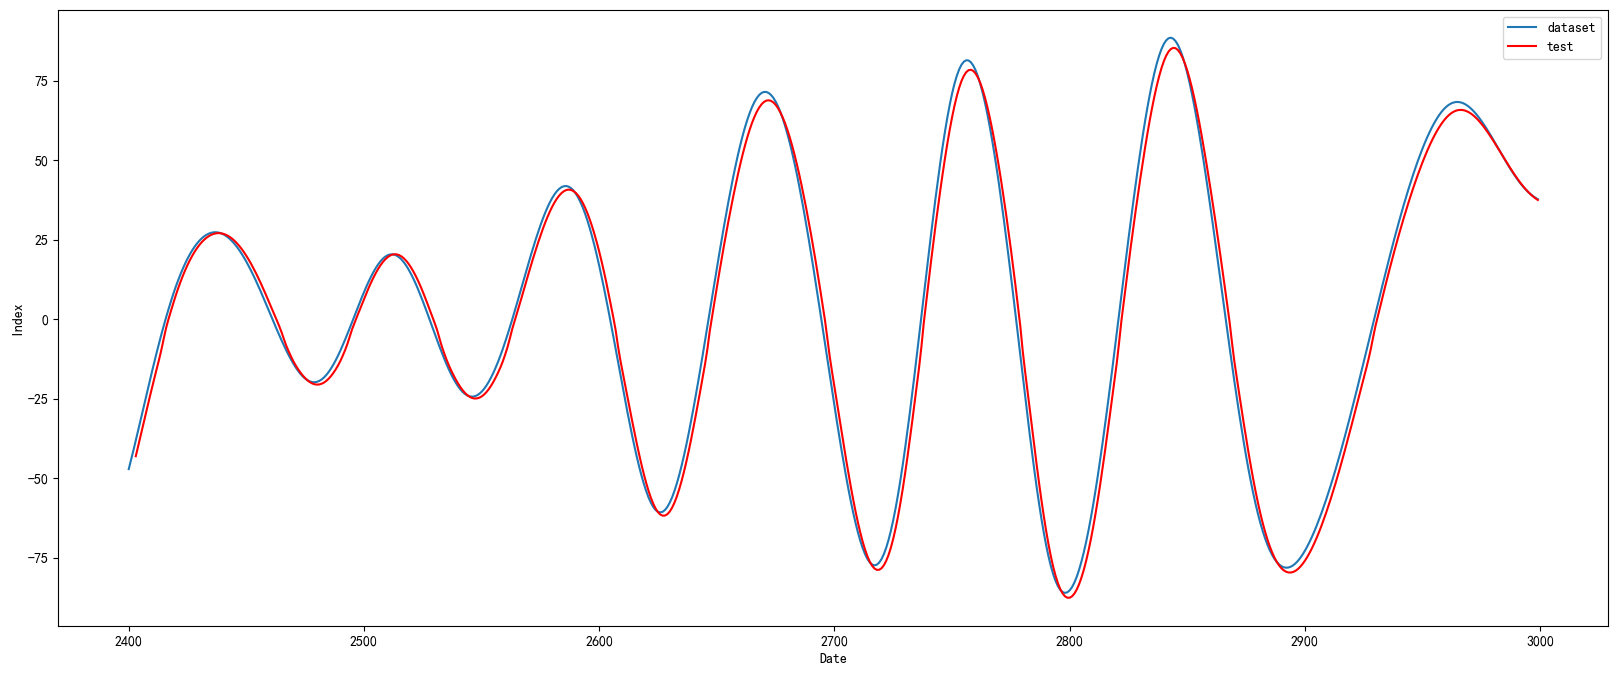

In [6]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index High modes_data.csv', index_col=0,usecols=[0,6])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF6_pre= pd.DataFrame(testPredict)
IMF6_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF7

<Figure size 2000x800 with 0 Axes>

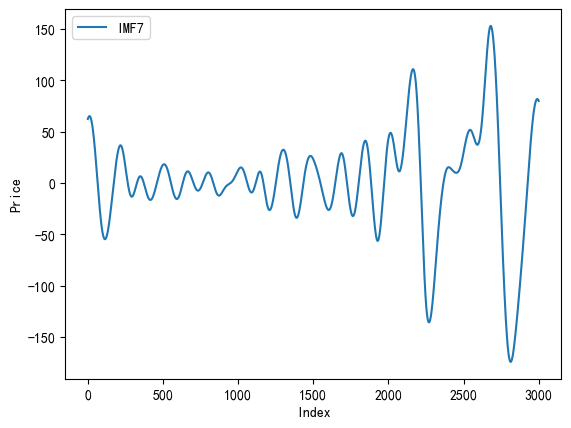

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_5 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 activation_5 (Activation)   (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

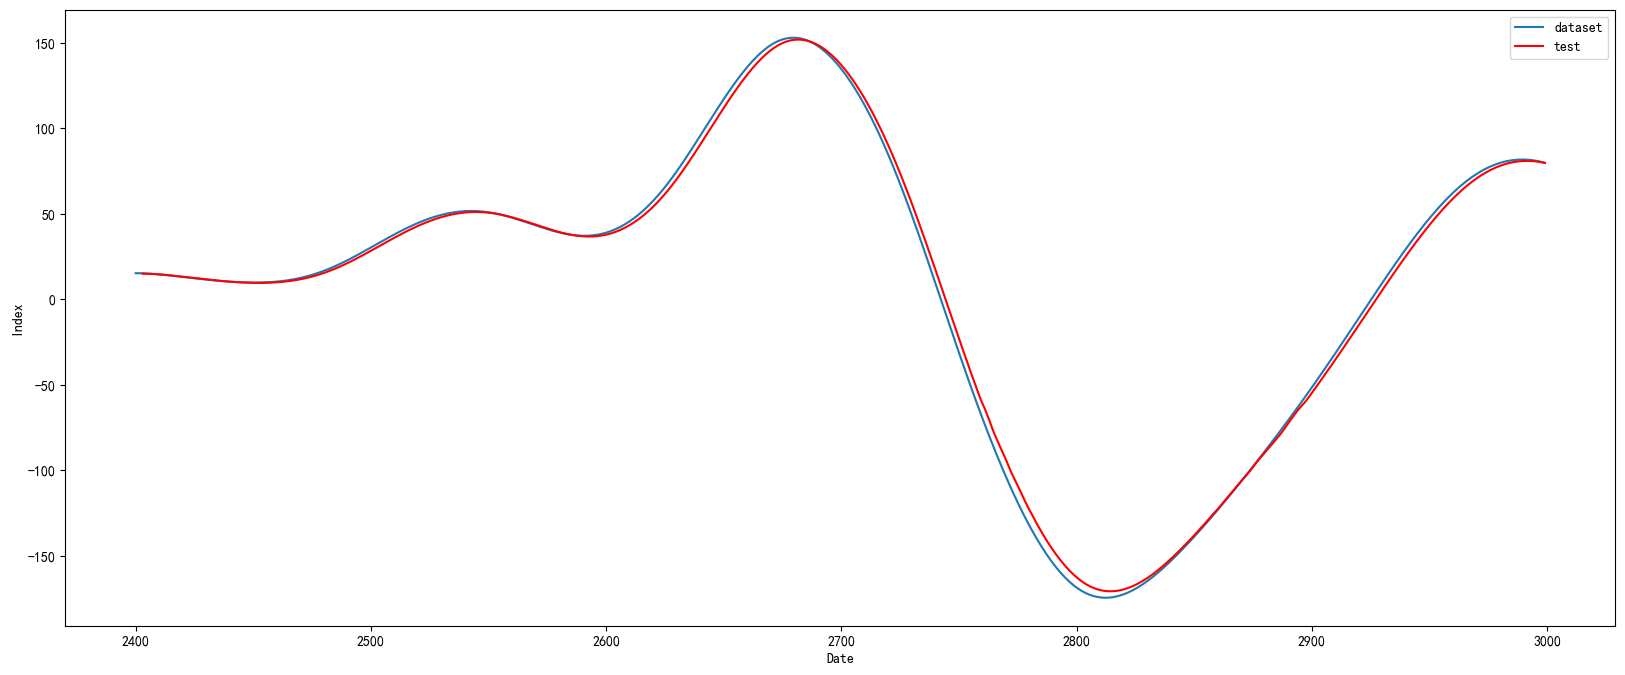

In [7]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index High modes_data.csv', index_col=0,usecols=[0,7])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF7_pre= pd.DataFrame(testPredict)
IMF7_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF8

<Figure size 2000x800 with 0 Axes>

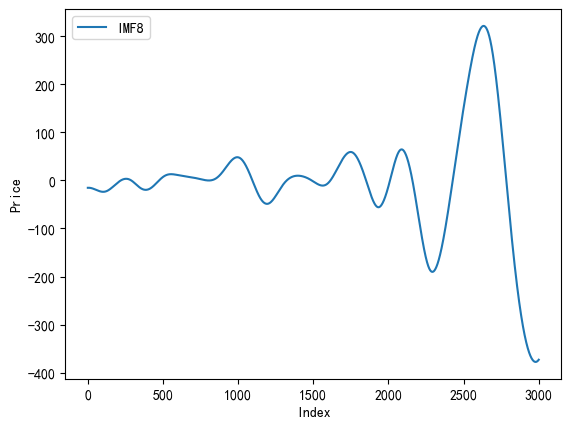

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 3, 64)            8704      
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 64)            4161      
 )                                                               
                                                                 
 tcn_6 (TCN)                 (None, 32)                20768     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 activation_6 (Activation)   (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

135/135 [==============================] - 1s 6ms/step - loss: 1.1504e-04 - mae: 0.0078 - val_loss: 8.1667e-04 - val_mae: 0.0263
Epoch 51/100
135/135 [==============================] - 1s 6ms/step - loss: 1.0929e-04 - mae: 0.0077 - val_loss: 0.0012 - val_mae: 0.0316
Epoch 52/100
135/135 [==============================] - 1s 6ms/step - loss: 1.1158e-04 - mae: 0.0078 - val_loss: 7.3155e-04 - val_mae: 0.0246
Epoch 53/100
135/135 [==============================] - 1s 6ms/step - loss: 1.3124e-04 - mae: 0.0086 - val_loss: 7.7546e-05 - val_mae: 0.0072
Epoch 54/100
135/135 [==============================] - 1s 6ms/step - loss: 1.1423e-04 - mae: 0.0077 - val_loss: 1.9235e-04 - val_mae: 0.0123
Epoch 55/100
135/135 [==============================] - 1s 6ms/step - loss: 1.0146e-04 - mae: 0.0074 - val_loss: 2.2967e-04 - val_mae: 0.0133
Epoch 56/100
135/135 [==============================] - 1s 6ms/step - loss: 9.9096e-05 - mae: 0.0073 - val_loss: 9.4691e-04 - val_mae: 0.0288
Epoch 57/100
135/135 [=

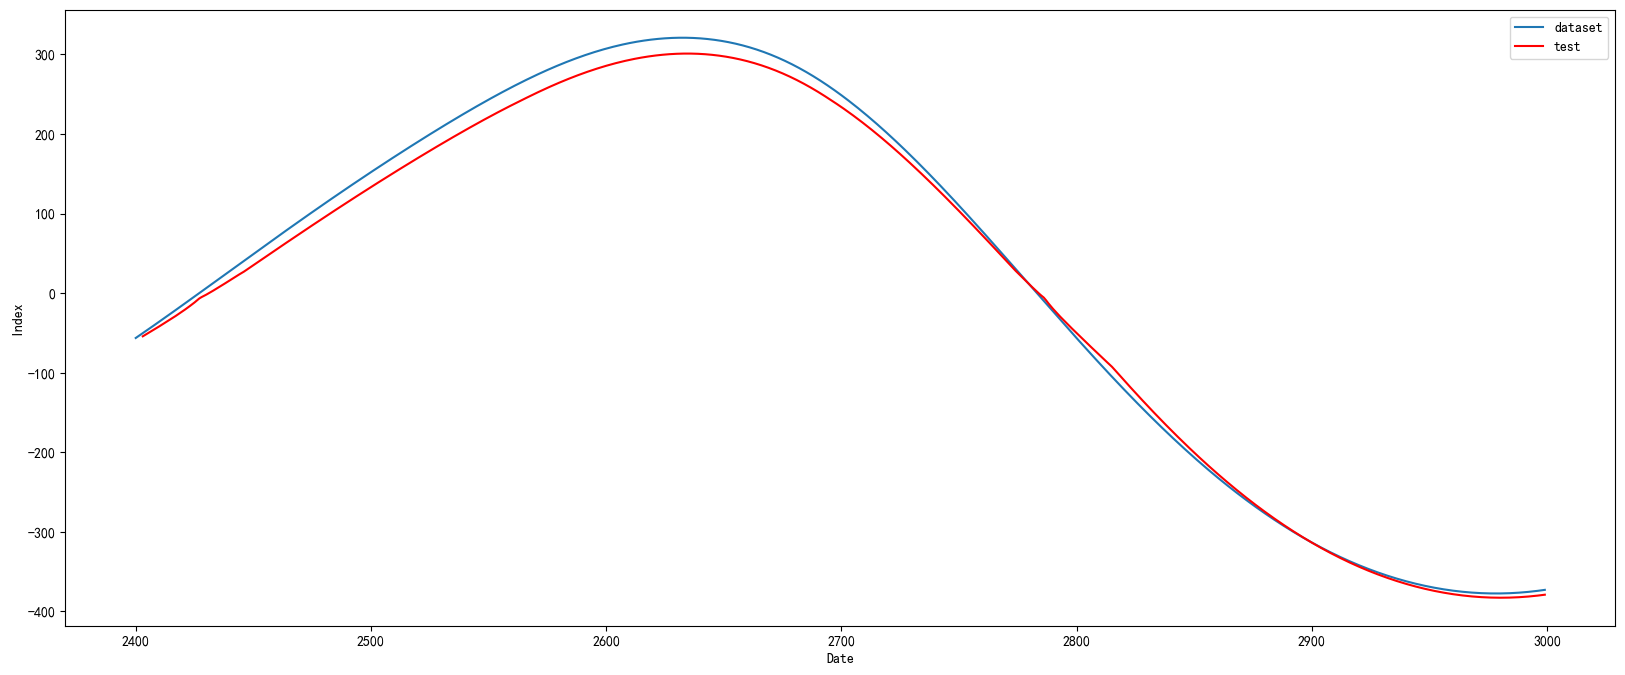

In [8]:
seed_value = 0
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index High modes_data.csv', index_col=0,usecols=[0,8])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(32,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=16, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF8_pre= pd.DataFrame(testPredict)
IMF8_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF9

<Figure size 2000x800 with 0 Axes>

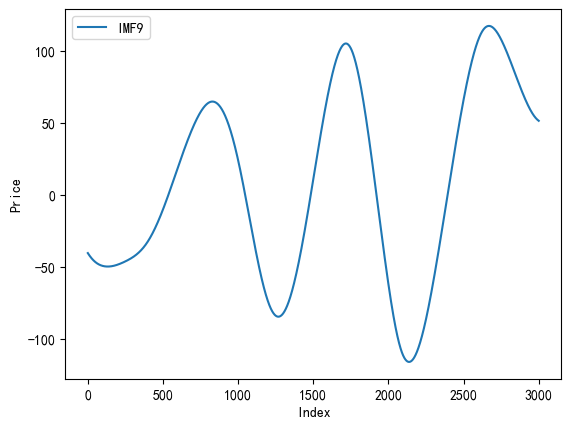

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 3, 128)           33792     
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_7 (TCN)                 (None, 32)                26912     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 activation_7 (Activation)   (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

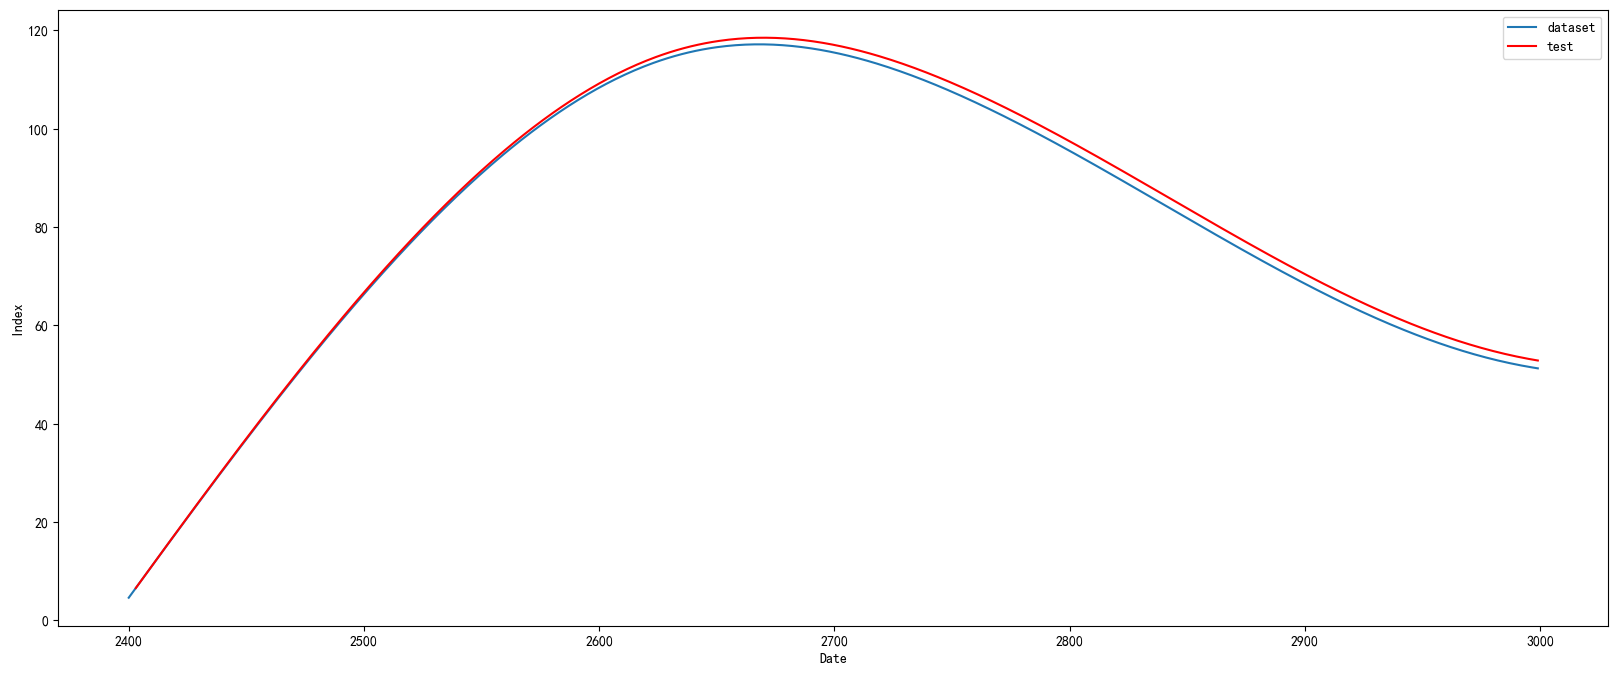

In [9]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index High modes_data.csv', index_col=0,usecols=[0,9])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF9_pre= pd.DataFrame(testPredict)
IMF9_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# Res

<Figure size 2000x800 with 0 Axes>

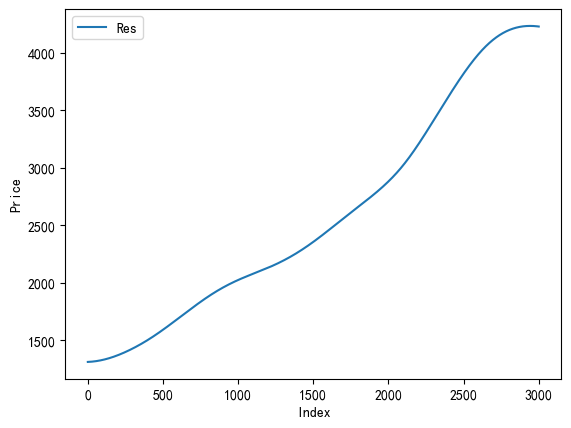

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 3, 128)           33792     
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_8 (TCN)                 (None, 32)                26912     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 activation_8 (Activation)   (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

68/68 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0235 - val_loss: 8.8786e-05 - val_mae: 0.0094
Epoch 51: early stopping
75/75 [==============================] - 0s 3ms/step - loss: 3.9892e-05 - mae: 0.0056
3.9891823689686134e-05 0.00555820669978857
19/19 [==============================] - 1s 3ms/step
Test Sccore 0.0392 MAPE
Test Score: 1.6105 MAE
Test Score: 1.7414 RMSE


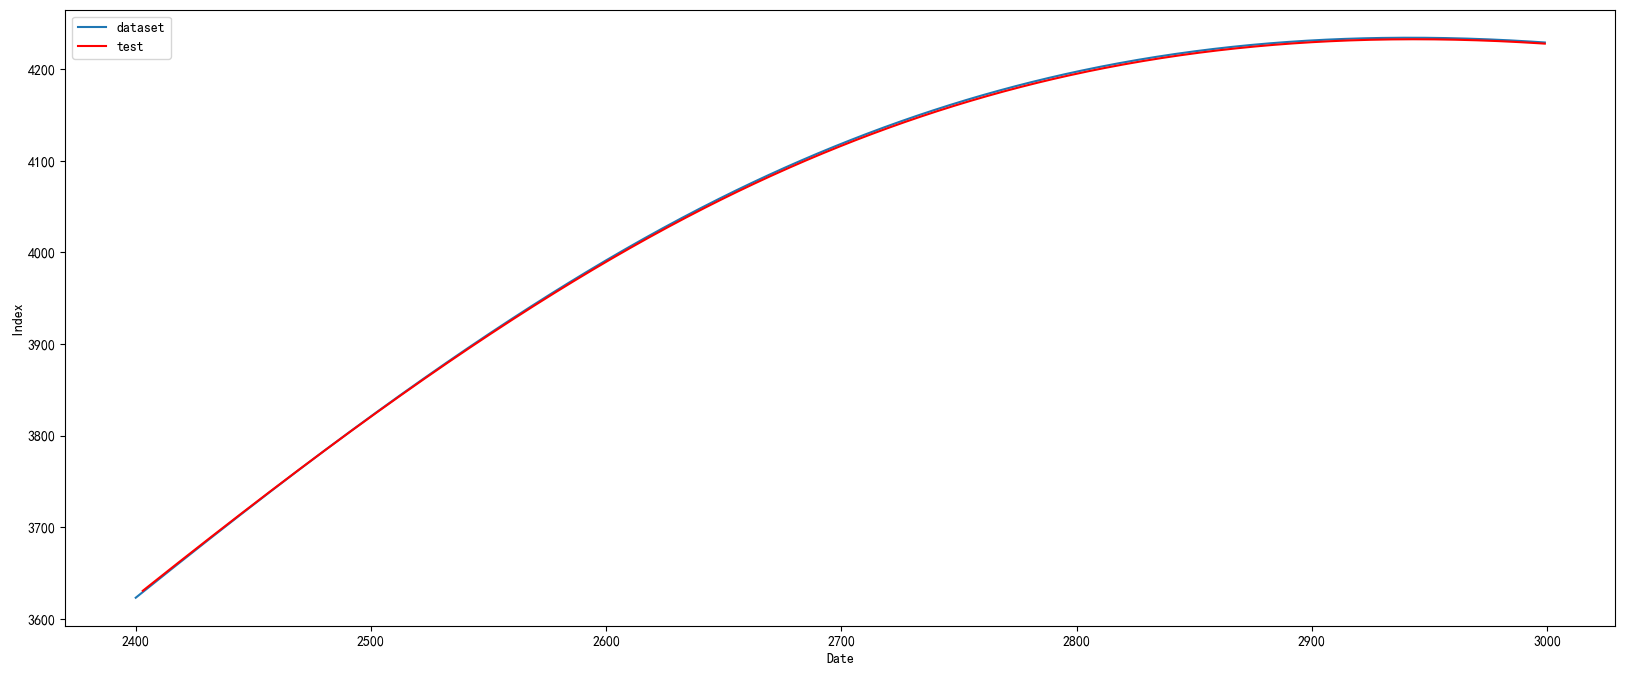

In [10]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index High modes_data.csv', index_col=0,usecols=[0,10])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
Res_pre= pd.DataFrame(testPredict)
Res_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# VIMF1

<Figure size 2000x800 with 0 Axes>

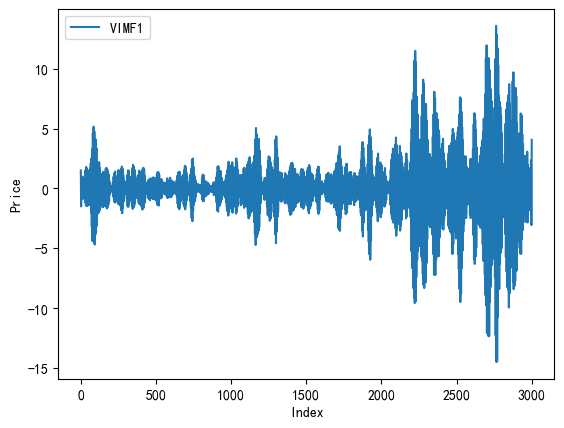

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 3, 128)           33792     
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_9 (TCN)                 (None, 32)                26912     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 activation_9 (Activation)   (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

68/68 [==============================] - 1s 10ms/step - loss: 3.5060e-04 - mae: 0.0141 - val_loss: 0.0020 - val_mae: 0.0347
Epoch 53/100
68/68 [==============================] - 1s 10ms/step - loss: 3.4029e-04 - mae: 0.0138 - val_loss: 0.0014 - val_mae: 0.0303
Epoch 54/100
68/68 [==============================] - 1s 9ms/step - loss: 3.5310e-04 - mae: 0.0142 - val_loss: 0.0021 - val_mae: 0.0355
Epoch 55/100
68/68 [==============================] - 1s 10ms/step - loss: 3.3243e-04 - mae: 0.0135 - val_loss: 0.0013 - val_mae: 0.0283
Epoch 56/100
68/68 [==============================] - 1s 10ms/step - loss: 3.3655e-04 - mae: 0.0132 - val_loss: 0.0015 - val_mae: 0.0296
Epoch 57/100
68/68 [==============================] - 1s 11ms/step - loss: 3.3823e-04 - mae: 0.0138 - val_loss: 0.0013 - val_mae: 0.0286
Epoch 58/100
68/68 [==============================] - 1s 10ms/step - loss: 3.1633e-04 - mae: 0.0133 - val_loss: 0.0014 - val_mae: 0.0287
Epoch 59/100
68/68 [==============================] - 1

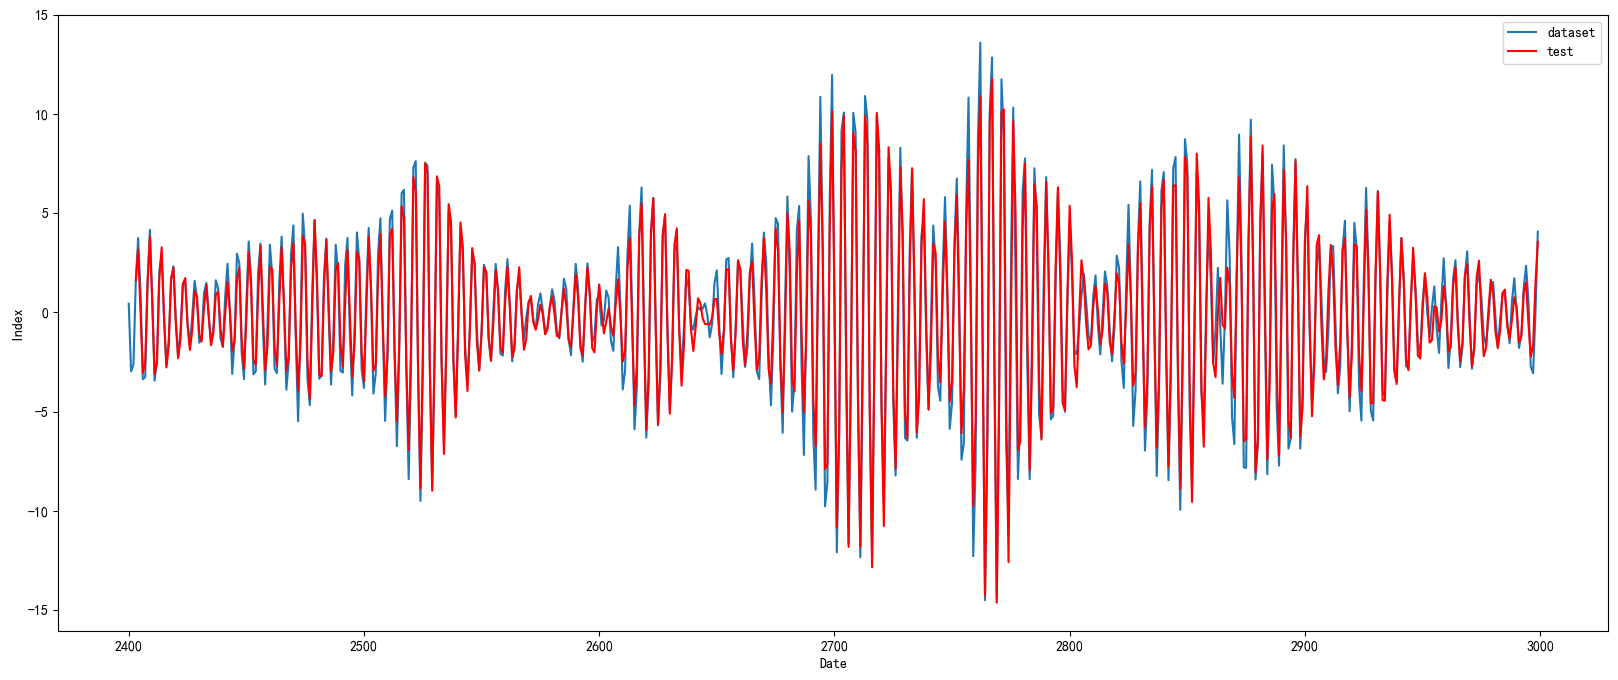

In [11]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./S&P 500 Index High VIMFs.csv', index_col=0,usecols=[0,1])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
VIMF1_pre= pd.DataFrame(testPredict)
VIMF1_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# VIMF2

<Figure size 2000x800 with 0 Axes>

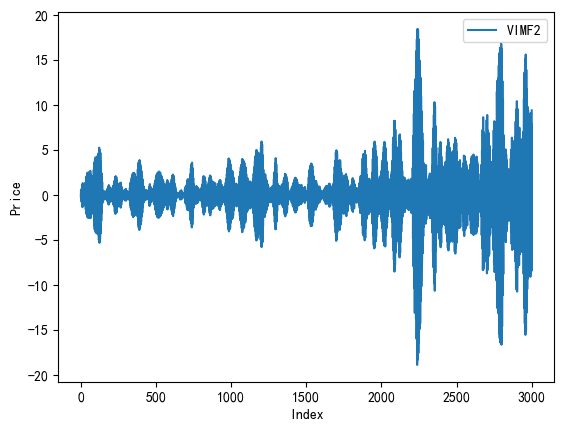

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 3, 128)           33792     
 onal)                                                           
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_10 (TCN)                (None, 32)                26912     
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 activation_10 (Activation)  (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)               

Epoch 52/100
68/68 [==============================] - 1s 10ms/step - loss: 3.9117e-04 - mae: 0.0147 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 53/100
68/68 [==============================] - 1s 10ms/step - loss: 3.3845e-04 - mae: 0.0135 - val_loss: 0.0015 - val_mae: 0.0294
Epoch 54/100
68/68 [==============================] - 1s 11ms/step - loss: 3.3846e-04 - mae: 0.0135 - val_loss: 0.0011 - val_mae: 0.0241
Epoch 55/100
68/68 [==============================] - 1s 9ms/step - loss: 3.1377e-04 - mae: 0.0130 - val_loss: 0.0013 - val_mae: 0.0268
Epoch 56/100
68/68 [==============================] - 1s 9ms/step - loss: 4.0336e-04 - mae: 0.0151 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 57/100
68/68 [==============================] - 1s 9ms/step - loss: 3.7560e-04 - mae: 0.0144 - val_loss: 0.0011 - val_mae: 0.0249
Epoch 58/100
68/68 [==============================] - 1s 10ms/step - loss: 3.3953e-04 - mae: 0.0139 - val_loss: 9.9736e-04 - val_mae: 0.0241
Epoch 59/100
68/68 [====================

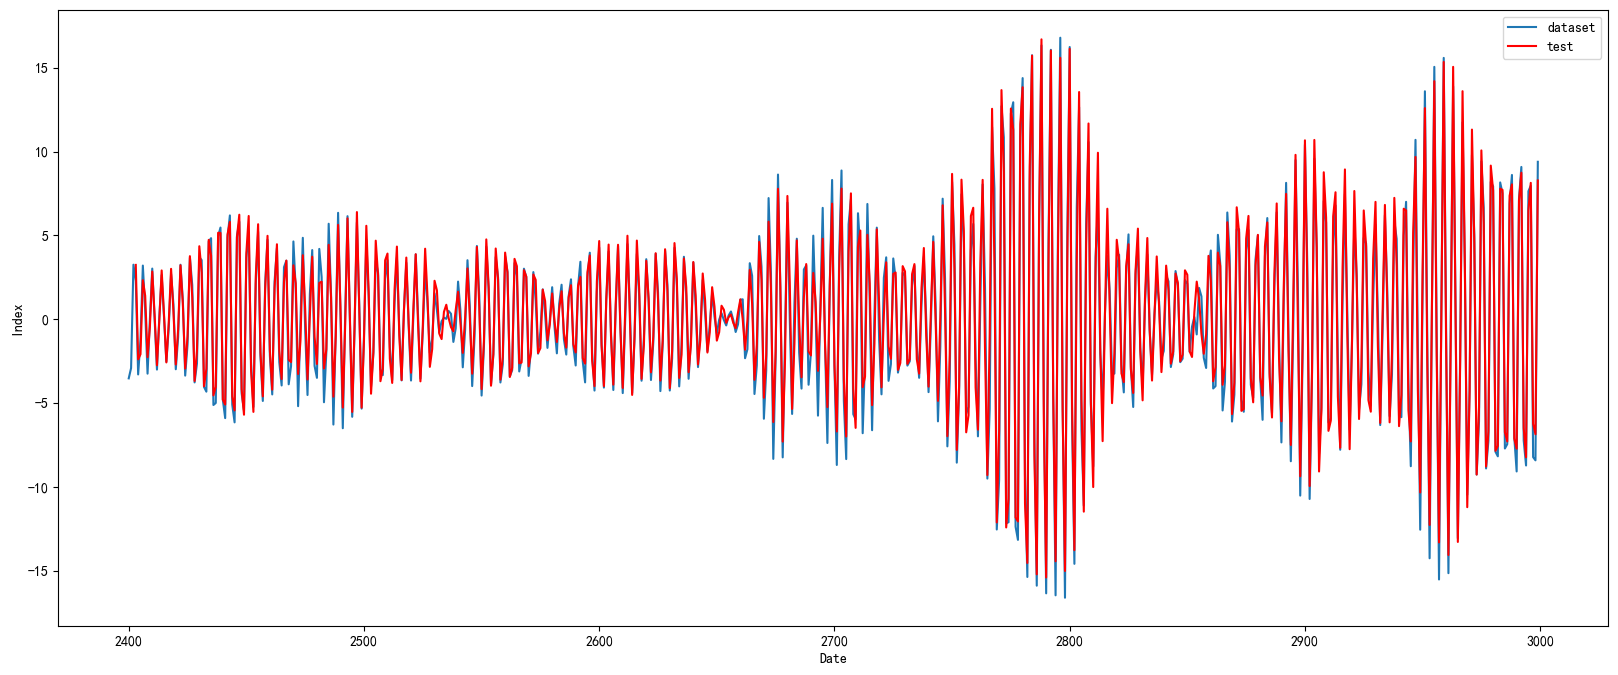

In [12]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./S&P 500 Index High VIMFs.csv', index_col=0,usecols=[0,2])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
VIMF2_pre= pd.DataFrame(testPredict)
VIMF2_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# VIMF3

<Figure size 2000x800 with 0 Axes>

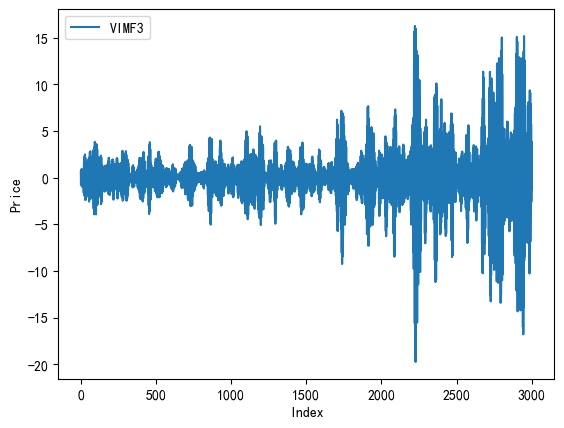

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 3, 128)           33792     
 onal)                                                           
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_11 (TCN)                (None, 32)                26912     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 activation_11 (Activation)  (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)               

68/68 [==============================] - 1s 9ms/step - loss: 3.7342e-04 - mae: 0.0147 - val_loss: 0.0017 - val_mae: 0.0275
Epoch 53/100
68/68 [==============================] - 1s 9ms/step - loss: 3.6316e-04 - mae: 0.0141 - val_loss: 0.0017 - val_mae: 0.0266
Epoch 54/100
68/68 [==============================] - 1s 10ms/step - loss: 2.9238e-04 - mae: 0.0130 - val_loss: 0.0017 - val_mae: 0.0286
Epoch 55/100
68/68 [==============================] - 1s 9ms/step - loss: 3.3606e-04 - mae: 0.0138 - val_loss: 0.0017 - val_mae: 0.0280
Epoch 56/100
68/68 [==============================] - 1s 9ms/step - loss: 3.7152e-04 - mae: 0.0147 - val_loss: 0.0018 - val_mae: 0.0279
Epoch 57/100
68/68 [==============================] - 1s 9ms/step - loss: 4.0738e-04 - mae: 0.0154 - val_loss: 0.0020 - val_mae: 0.0296
Epoch 58/100
68/68 [==============================] - 1s 9ms/step - loss: 3.2131e-04 - mae: 0.0133 - val_loss: 0.0019 - val_mae: 0.0293
Epoch 59/100
68/68 [==============================] - 1s 9ms

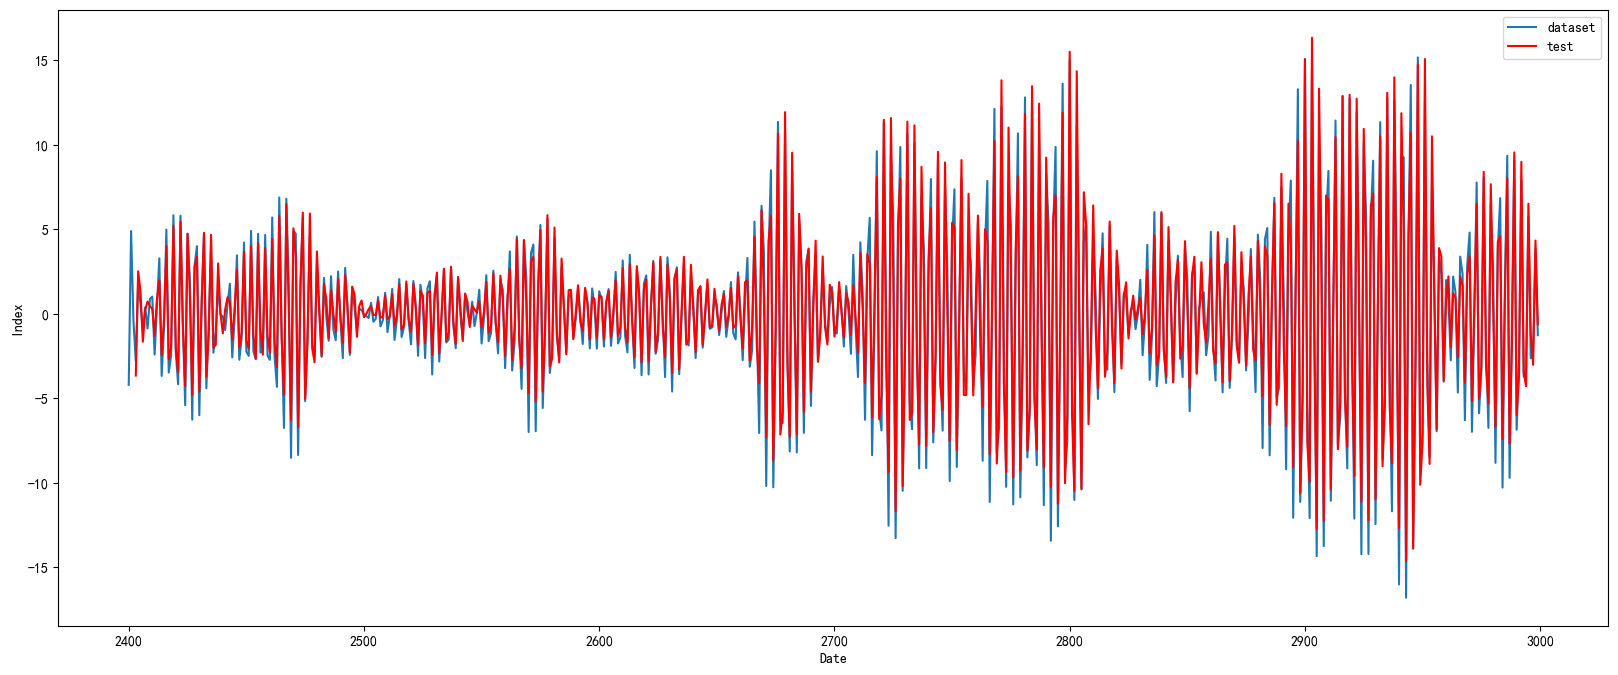

In [13]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./S&P 500 Index High VIMFs.csv', index_col=0,usecols=[0,3])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
VIMF3_pre= pd.DataFrame(testPredict)
VIMF3_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# Original

<Figure size 2000x800 with 0 Axes>

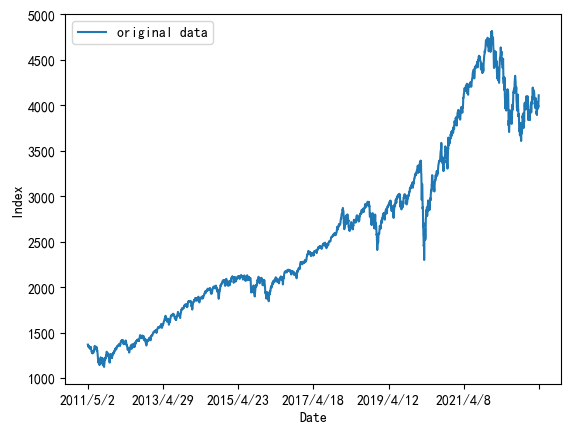

In [14]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
dataframe = read_csv('./S&P 500 Index High.csv', index_col=0,usecols=[0,1])
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Date')
plt.ylabel('Index')
plt.yticks()
plt.legend(['original data'])
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :] 


trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back) 

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


testY = scaler.inverse_transform([testY])

Original_pre= pd.DataFrame(testPredict)
Original_true= pd.DataFrame(testY[0])

In [15]:
testPredict=pd.concat([IMF2_pre,
                       IMF3_pre,
                       IMF4_pre,
                       IMF5_pre,
                       IMF6_pre,
                       IMF7_pre,
                       IMF8_pre,
                       IMF9_pre,
                       Res_pre,
                       VIMF1_pre,
                       VIMF2_pre,
                       VIMF3_pre,],axis=1)  # 横向合并


testPredict["pre_sum"]=testPredict.sum(axis=1)

testPredict["Original_true"]=Original_true

In [16]:
testScore_2= mape(testPredict["Original_true"], testPredict["pre_sum"])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testPredict["Original_true"], testPredict["pre_sum"])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testPredict["Original_true"], testPredict["pre_sum"]))
print('Test Score: %.4f RMSE' % (testScore))

Test Sccore 0.4770 MAPE
Test Score: 19.9547 MAE
Test Score: 23.7603 RMSE


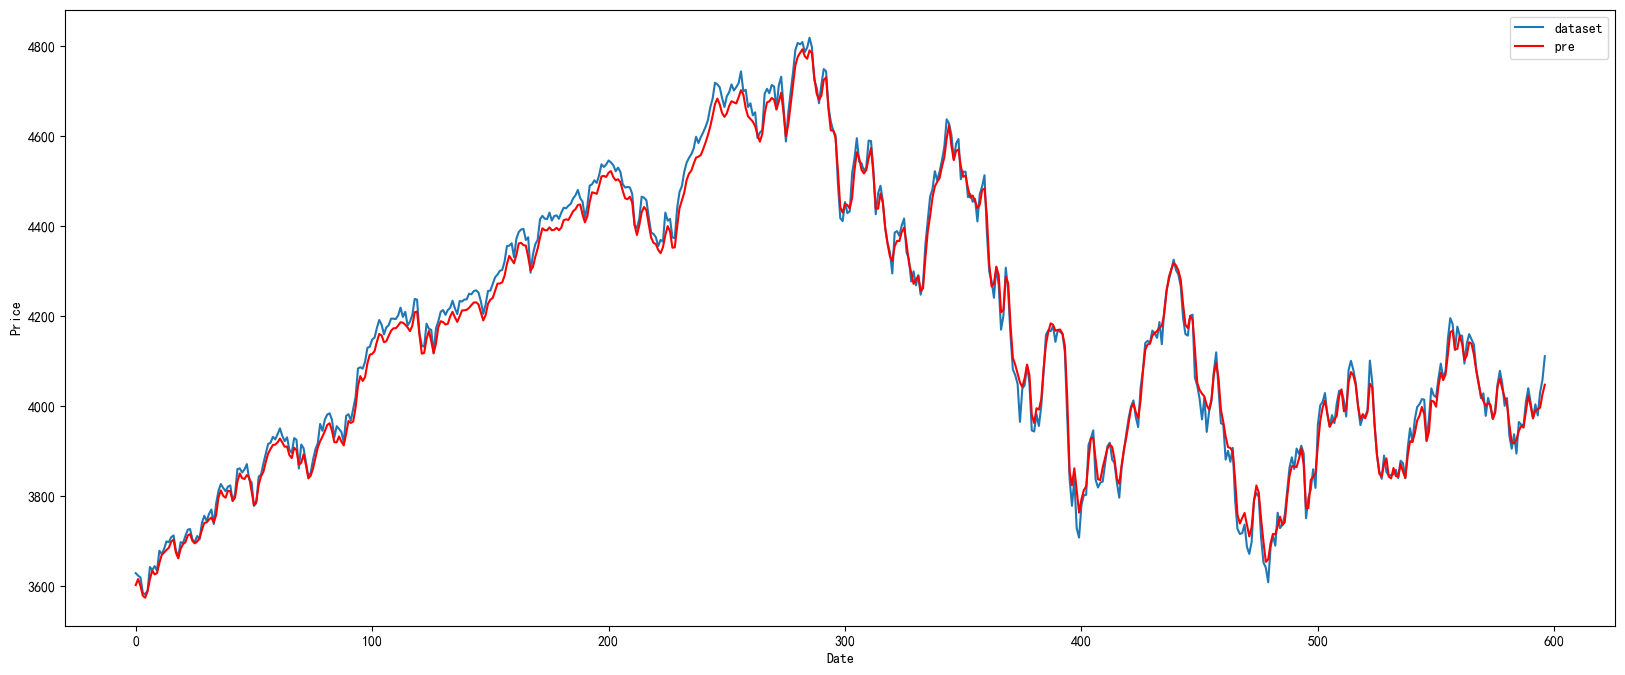

In [17]:
plt.figure(figsize=(20,8))
plt.plot(testPredict["Original_true"], label='dataset')
plt.plot(testPredict["pre_sum"],color='r', label='pre')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [18]:
# 最终集成并写入csv
Finally_excel=testPredict

Finally_excel.to_csv('./Finally_excel.csv')

In [19]:
end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

Execution time: 765.63 seconds
